In [7]:
import numpy as np
import supervision as sv
from ultralytics import YOLO
from roboflow import Roboflow
from inference import get_model
import matplotlib.pyplot as plt
import cv2

from sports.common.view import ViewTransformer
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

In [2]:
ROBOFLOW_API_KEY = "UVmBfxv61kyodJYkOtNI"
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
SOURCE_VIDEO_PATH = "121364_0.mp4"

In [4]:
!ls

121364_0.mp4                results.csv
best.pt                     results.png
football-field-detection-14 roboflow_demo.ipynb
last.pt                     soccernet.yaml
output_homografia.mp4       soccernet_dataset
predict_and_visualize.py    soccernet_raw
preprocess_dataset.py       sports
resultado_cancha.mp4        train.py


In [5]:
rf = Roboflow(api_key="UVmBfxv61kyodJYkOtNI")

workspace = rf.workspace("roboflow-jvuqo")
project = workspace.project("football-field-detection-f07vi")
version = project.version(14)
dataset = version.download("yolov8")

# FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)
FIELD_DETECTION_MODEL = model = YOLO('last.pt')

loading Roboflow workspace...
loading Roboflow project...


## Pitch keypoint detection


0: 384x640 2 pitchs, 436.5ms
Speed: 1.7ms preprocess, 436.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


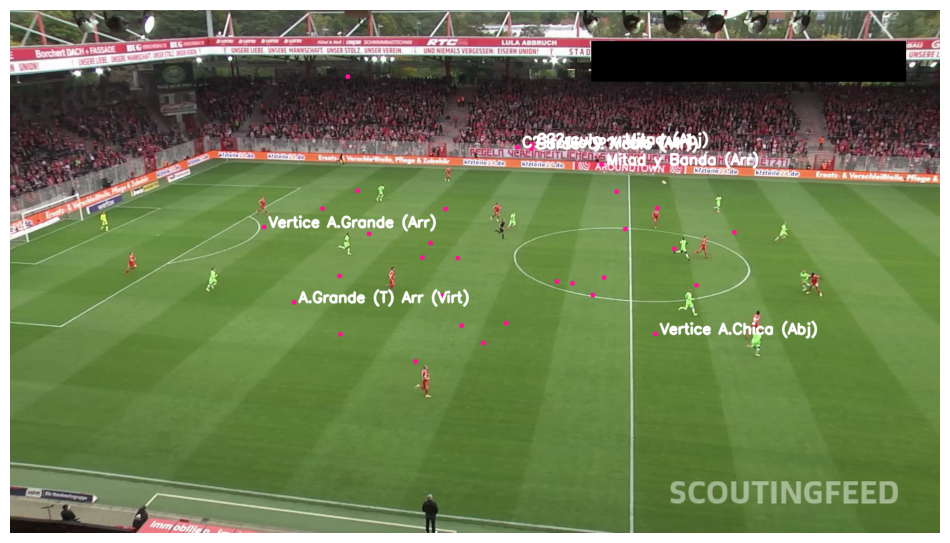

In [ ]:
KP_NAMES = {
    # --- IZQUIERDA (El arco de la izquierda) ---
    0:  "Corner Sup. Izq.",          # TL Corner
    1:  "Fondo y A.Grande (Arr)",    # Cruce linea fondo con area grande arriba
    2:  "Fondo y A.Chica (Arr)",     # Cruce linea fondo con area chica arriba
    3:  "Fondo y A.Chica (Abj)",     # Cruce linea fondo con area chica abajo
    4:  "Fondo y A.Grande (Abj)",    # Cruce linea fondo con area grande abajo
    5:  "Corner Inf. Izq.",          # BL Corner
    6:  "Vertice A.Chica (Arr)",     # Punta area chica arriba
    7:  "Vertice A.Chica (Abj)",     # Punta area chica abajo
    8:  "Punto Penal (Izq)",         # El punto fatídico
    9:  "Vertice A.Grande (Arr)",    # Punta area grande arriba
    10: "A.Grande (T) Arr (Virt)",   # Punto virtual (interseccion proyección)
    11: "A.Grande (T) Abj (Virt)",   # Punto virtual
    12: "Vertice A.Grande (Abj)",    # Punta area grande abajo
    
    # --- MEDIO CAMPO ---
    13: "Mitad y Banda (Arr)",       # Linea mitad cancha arriba
    14: "Círculo y Mitad (Arr)",     # Donde corta el circulo arriba
    15: "El Medio",                  # Punto central / Saque
    16: "Círculo y Mitad (Abj)",     # Donde corta el circulo abajo
    17: "Mitad y Banda (Abj)",       # Linea mitad cancha abajo
    
    # --- DERECHA (El arco de la derecha) ---
    18: "Vertice A.Grande (Arr)",    # Idem lado derecho...
    19: "A.Grande (T) Arr (Virt)",
    20: "A.Grande (T) Abj (Virt)",
    21: "Vertice A.Grande (Abj)",
    22: "Punto Penal (Der)",
    23: "Vertice A.Chica (Arr)",
    24: "Vertice A.Chica (Abj)",
    25: "Corner Sup. Der.",
    26: "Fondo y A.Grande (Arr)",
    27: "Fondo y A.Chica (Arr)",
    28: "Fondo y A.Chica (Abj)",
    29: "Fondo y A.Grande (Abj)",
    30: "Corner Inf. Der.",
    31: "Borde Círculo (Virt)"       # Un punto extra en el borde del círculo
}

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=5  # Made dots slightly smaller so text fits
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

if frame is not None:
    results = FIELD_DETECTION_MODEL(frame, conf=0.3)[0]
    key_points = sv.KeyPoints.from_ultralytics(results)

    # Se queda solo con la detección de mayor confianza
    if len(results.boxes) > 0:
        best_idx = results.boxes.conf.argmax()
        # Keep dimensions with double brackets [[ ]]
        key_points = key_points[[best_idx]]
    
    annotated_frame = frame.copy()
    annotated_frame = vertex_annotator.annotate(
        scene=annotated_frame,
        key_points=key_points
    )

    xy = key_points.xy[0]
    conf = key_points.confidence[0]

    for i, (x, y) in enumerate(xy):
        if conf[i] > 0.5:
            label = KP_NAMES.get(i, str(i)) 
            
            cv2.putText(
                annotated_frame,
                label,
                (int(x) + 10, int(y)),      # Shift text slightly right
                cv2.FONT_HERSHEY_SIMPLEX,
                1,                        # Font scale
                (255, 255, 255),            # White text
                3,                          # Thickness
                cv2.LINE_AA
            )

    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


0: 384x640 2 pitchs, 348.1ms
Speed: 1.7ms preprocess, 348.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


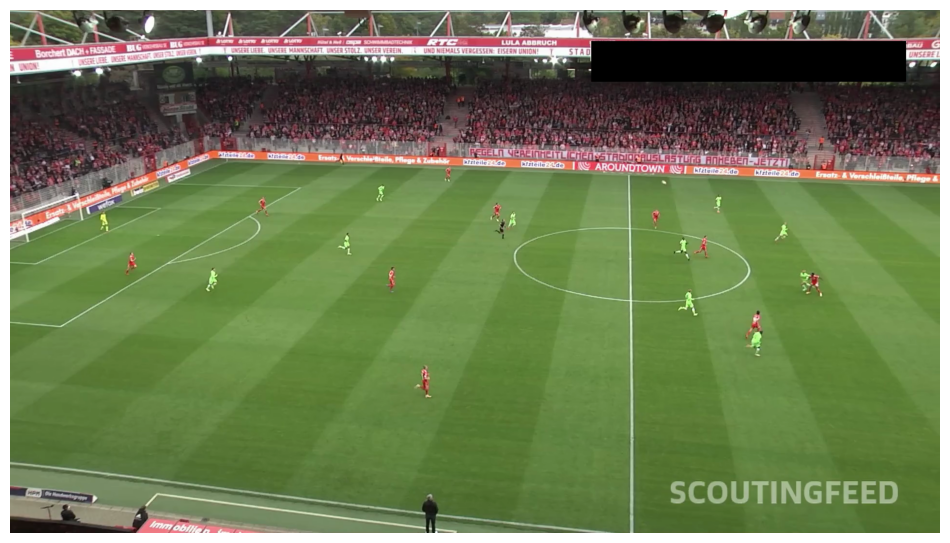

In [9]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame = next(frame_generator)

result = FIELD_DETECTION_MODEL(frame, conf=0.3)[0]
key_points = sv.KeyPoints.from_ultralytics(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

## Proyect pitch lines on frame

In [10]:
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL(frame, conf=0.3)[0]
key_points = sv.KeyPoints.from_ultralytics(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)


0: 384x640 1 pitch, 345.1ms
Speed: 1.5ms preprocess, 345.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


error: OpenCV(4.12.0) /Users/runner/miniforge3/conda-bld/libopencv_1760191551910/work/modules/calib3d/src/fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import random

# CONFIG
dataset_path = "./soccernet_dataset/train"
image_dir = os.path.join(dataset_path, "images")
label_dir = os.path.join(dataset_path, "labels")

# 1. Pick a random file
img_files = os.listdir(image_dir)
random_file = random.choice(img_files)
base_name = os.path.splitext(random_file)[0]

# 2. Load Image
img_path = os.path.join(image_dir, random_file)
img = cv2.imread(img_path)
h, w = img.shape[:2]

# 3. Load Label
label_path = os.path.join(label_dir, base_name + ".txt")
with open(label_path, 'r') as f:
    data = f.read().strip().split()

# 4. Parse YOLO Label (Class, cx, cy, w, h, p1_x, p1_y, p1_v, ...)
# Skip first 5 items (box info) -> Start at index 5
keypoints = [float(x) for x in data[5:]]

# 5. Draw
plt.figure(figsize=(12, 8))
# Plot points
for i in range(0, len(keypoints), 3):
    px, py, vis = keypoints[i], keypoints[i+1], keypoints[i+2]
    if vis > 0: # 0=invisible, 1=visible, 2=visible
        # YOLO coords are normalized 0-1, convert to pixels
        cx, cy = int(px * w), int(py * h)
        cv2.circle(img, (cx, cy), 5, (0, 255, 0), -1) # Green dots
        cv2.putText(img, str(i//3), (cx+5, cy-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Training Data Check: {random_file}")
plt.axis('off')
plt.show()

IndexError: Cannot choose from an empty sequence